In [1]:
import os
import pandas as pd
from tbparse import SummaryReader

base = r"..\..\data"

def read_tb(base, filename):
    reader = SummaryReader(os.path.join(base, filename))
    df = reader.scalars
    return df

def get_data_array(df, tag):
    return df[df.tag.str.contains(tag)]['value'].to_numpy().squeeze()

def filter_df(df):
    return get_data_array(df, 'Eval_AverageReturn'), get_data_array(df, 'Eval_StdReturn')

## Problem 1

For BC Ant, we use the following choice of parameters, which is the default parameters except where noted.

```python
  #@markdown expert data
  expert_policy_file = 'cs285/policies/experts/Ant.pkl' #@param
  expert_data = 'cs285/expert_data/expert_data_Ant-v4.pkl' #@param
  env_name = 'Ant-v4' #@param ['Ant-v4', 'Walker2d-v4', 'HalfCheetah-v4', 'Hopper-v4']
  exp_name = 'bc_Ant' #@param
  do_dagger = False #@param {type: "boolean"}
  ep_len = 10000 #@param {type: "integer"}
  save_params = False #@param {type: "boolean"}

  num_agent_train_steps_per_iter = 10000 #@param {type: "integer"})
  n_iter = 1 #@param {type: "integer"})

  #@markdown batches & buffers
  batch_size = 10000 #@param {type: "integer"})
  eval_batch_size = 10000 #@param {type: "integer"}
  train_batch_size = 100 #@param {type: "integer"}
  max_replay_buffer_size = 1000000 #@param {type: "integer"}

  #@markdown network
  n_layers = 2 #@param {type: "integer"}
  size = 64 #@param {type: "integer"}
  learning_rate = 5e-3 #@param {type: "number"}

  #@markdown logging
  video_log_freq = -1 #@param {type: "integer"}
  scalar_log_freq = 1 #@param {type: "integer"}

  #@markdown gpu & run-time settings
  no_gpu = False #@param {type: "boolean"}
  which_gpu = 0 #@param {type: "integer"}
  seed = 1 #@param {type: "integer"}
```

The data is recorded in `q1_bc_Ant_10evals_Ant-v4_12-09-2022_09-09-39`.

In [2]:
df_bc_ant = read_tb(base, 'q1_bc_Ant_10evals_Ant-v4_12-09-2022_09-09-39');

Same parameters, just with the task changed to Hopper. We tried all four available tasks. The Hopper task is the only one that managed to reach below 30% with the above parameters. The agent is just too good.

The data is recorded in `q1_bc_Hopper_10evals_Hopper-v4_12-09-2022_09-12-03`

In [3]:
df_bc_hopper = read_tb(base, 'q1_bc_Hopper_10evals_Hopper-v4_12-09-2022_09-12-03');

In [4]:
print(filter_df(df_bc_ant))
print(get_data_array(df_bc_ant, 'Initial_DataCollection_AverageReturn'))
print(filter_df(df_bc_hopper))
print(get_data_array(df_bc_hopper, 'Initial_DataCollection_AverageReturn'))

(array(4730.07714844), array(97.9336853))
4713.6533203125
(array(984.69366455), array(156.83201599))
3772.67041015625


|           | mean of return | std of return | expert performance |
|-----------|----------------|---------------|--------------------|
| BC Ant    | 4730           | 98            | 4713               |
| BC Hopper | 984            | 156           | 3773               |
<center>
    <b>Table 1.</b> The mean and standard deviation of the policy returns over 10 evaluation rollouts, in Ant and Hopper environments. The hyperparameters are described above. Note that the mean of return for Ant is <em>larger</em> than the expert performance.
</center>

---

For experiment on Hopper, we changed the episodes per training iteration, because seeing the exponential convergence (in DAgger Hopper), we think that it lacks both expert data and training steps. We first tried varying only the number of episodes per training iteration from 1 gradually to 100, but obtained the same agent (up to floating point error). 

At first we thought there was a bug, but then I realized that the Behavior Cloning agent *NEVER* interacted with the environment! That's why it never improved -- it obtained exactly the same expert-behavior dataset, loaded from the pickled file! There's no bug in the code, only a bug in my mind.

So we varied number of training steps from $10^2$ to $10^6$ and got the desired variation in performance. It appears that the training has converged at $10^5$ steps, and just in time. To train it for $10^7$ steps would have costed 200 minutes of computing time.

The data is recorded in

* `q1_bc_Hopper_100trainsteps_Hopper-v4_12-09-2022_09-30-13`
* `q1_bc_Hopper_1000trainsteps_Hopper-v4_12-09-2022_09-31-01`
* `q1_bc_Hopper_10000trainsteps_Hopper-v4_12-09-2022_09-32-00`
* `q1_bc_Hopper_100000trainsteps_Hopper-v4_12-09-2022_09-32-41`
* `q1_bc_Hopper_1000000trainsteps_Hopper-v4_12-09-2022_09-35-42`

In [5]:
df_bc_hopper_1e2 = read_tb(base, 'q1_bc_Hopper_100trainsteps_Hopper-v4_12-09-2022_09-30-13')
df_bc_hopper_1e3 = read_tb(base, 'q1_bc_Hopper_1000trainsteps_Hopper-v4_12-09-2022_09-31-01')
df_bc_hopper_1e4 = read_tb(base, 'q1_bc_Hopper_10000trainsteps_Hopper-v4_12-09-2022_09-32-00')
df_bc_hopper_1e5 = read_tb(base, 'q1_bc_Hopper_100000trainsteps_Hopper-v4_12-09-2022_09-32-41')
df_bc_hopper_1e6 = read_tb(base, 'q1_bc_Hopper_1000000trainsteps_Hopper-v4_12-09-2022_09-35-42')

In [6]:
xs = [1e2, 1e3, 1e4, 1e5, 1e6]
ys = []
yerrs = []
for df in [df_bc_hopper_1e2, df_bc_hopper_1e3, df_bc_hopper_1e4, df_bc_hopper_1e5, df_bc_hopper_1e6]:
    ys.append(get_data_array(df, 'Eval_AverageReturn'))
    yerrs.append(get_data_array(df, 'Eval_StdReturn'))

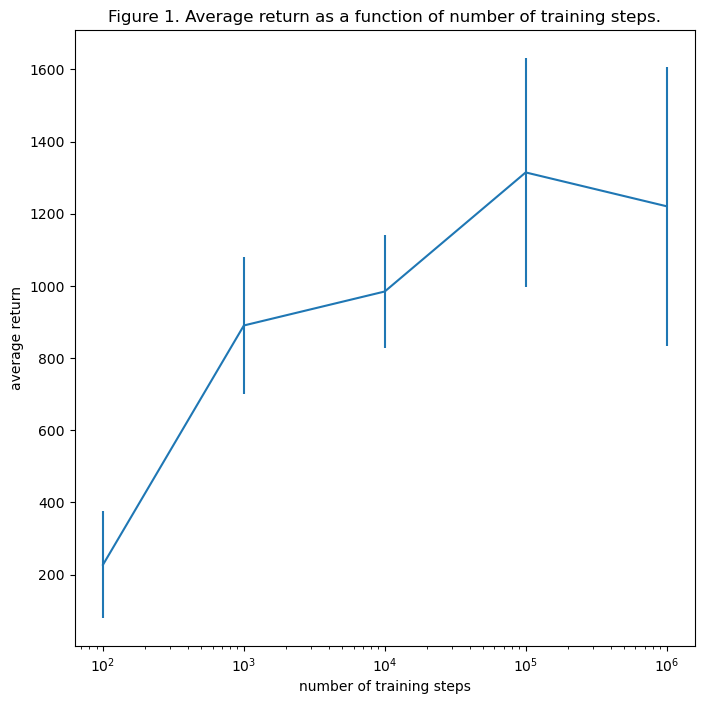

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.errorbar(xs, ys, yerr=yerrs)
plt.xscale('log')
caption = "Figure 2. "
plt.xlabel('number of training steps')
plt.ylabel('average return')
plt.title("Figure 1. Average return as a function of number of training steps.")
plt.show()

## Problem 2

The DAgger Ant experiment uses the same parameters as the BC Ant, but with 40 iterations.
```python
  #@markdown expert data
  expert_policy_file = 'cs285/policies/experts/Ant.pkl' #@param
  expert_data = 'cs285/expert_data/expert_data_Ant-v4.pkl' #@param
  env_name = 'Ant-v4' #@param ['Ant-v4', 'Walker2d-v4', 'HalfCheetah-v4', 'Hopper-v4']
  exp_name = 'dagger_ant_10eval' #@param
  do_dagger = True #@param {type: "boolean"}
  ep_len = 10000 #@param {type: "integer"}
  save_params = False #@param {type: "boolean"}

  num_agent_train_steps_per_iter = 10000 #@param {type: "integer"})
  n_iter = 40 #@param {type: "integer"})

  #@markdown batches & buffers
  batch_size = 10000 #@param {type: "integer"})
  eval_batch_size = 100000 #@param {type: "integer"}
  train_batch_size = 100 #@param {type: "integer"}
  max_replay_buffer_size = 1000000 #@param {type: "integer"}

  #@markdown network
  n_layers = 2 #@param {type: "integer"}
  size = 64 #@param {type: "integer"}
  learning_rate = 5e-3 #@param {type: "number"}

  #@markdown logging
  video_log_freq = -1 #@param {type: "integer"}
  scalar_log_freq = 1 #@param {type: "integer"}

  #@markdown gpu & run-time settings
  no_gpu = False #@param {type: "boolean"}
  which_gpu = 0 #@param {type: "integer"}
  seed = 1 #@param {type: "integer"}
```

The data is recorded in `q2_dagger_ant_10eval_Ant-v4_11-09-2022_22-38-54`

In [8]:
df_dagger_ant = read_tb(base, 'q2_dagger_ant_10eval_Ant-v4_11-09-2022_22-38-54')

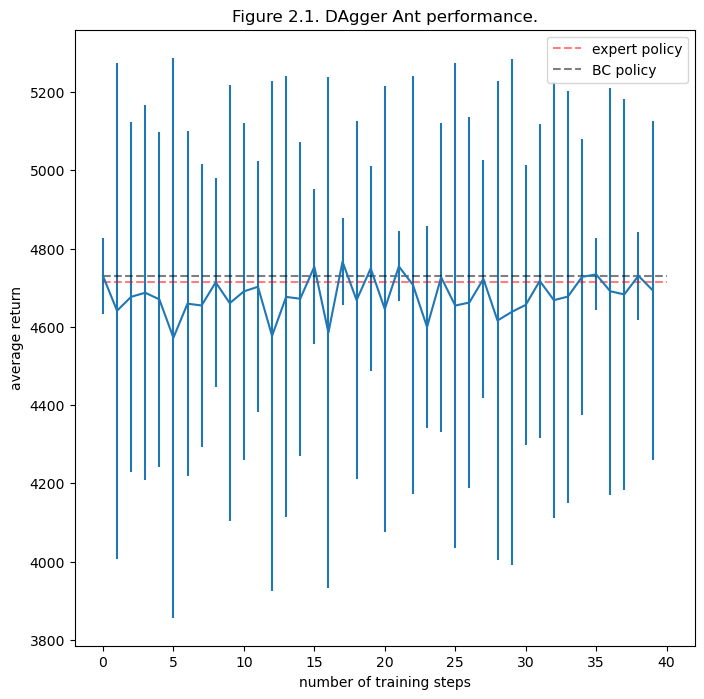

In [9]:
df = df_dagger_ant
ys, yerrs = filter_df(df)
reference_y = get_data_array(df, 'Initial_DataCollection_AverageReturn')[0]
reference_y_bc = get_data_array(df_bc_ant, 'Eval_AverageReturn')

plt.figure(figsize=(8, 8))
plt.errorbar(range(len(ys)), ys, yerr=yerrs)
plt.xlabel('number of training steps')
plt.ylabel('average return')
plt.hlines([reference_y], xmin = 0, xmax=len(ys), linestyle='--', color='red', alpha=0.5, 
           label="expert policy")
plt.hlines([reference_y_bc], xmin = 0, xmax=len(ys), linestyle='--', color='black', alpha=0.5, 
           label="BC policy")
plt.title("Figure 2.1. DAgger Ant performance.")
plt.legend()
plt.show()

The Hopper DAgger experiment uses the same parameters as the DAgger Ant, just with a different environment.

The data is recorded in `q2_dagger_hopper_10eval_Hopper-v4_11-09-2022_21-55-24`.

In [10]:
df_dagger_hopper = read_tb(base, 'q2_dagger_hopper_10eval_Hopper-v4_11-09-2022_21-55-24')

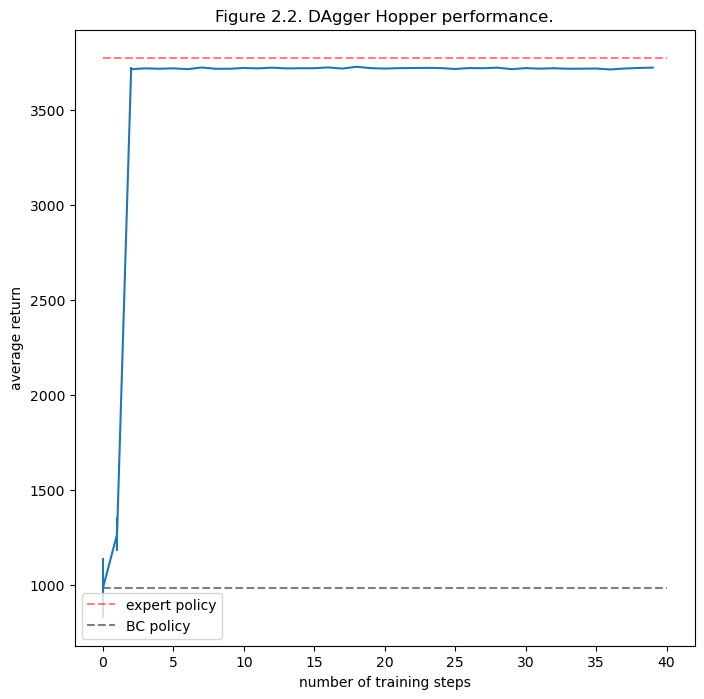

In [12]:
df = df_dagger_hopper
ys, yerrs = filter_df(df)
reference_y = get_data_array(df, 'Initial_DataCollection_AverageReturn')[0]
reference_y_bc = get_data_array(df_bc_hopper, 'Eval_AverageReturn')

plt.figure(figsize=(8, 8))
plt.errorbar(range(len(ys)), ys, yerr=yerrs)
plt.xlabel('number of training steps')
plt.ylabel('average return')
plt.hlines([reference_y], xmin = 0, xmax=len(ys), linestyle='--', color='red', alpha=0.5, 
           label="expert policy")
plt.hlines([reference_y_bc], xmin = 0, xmax=len(ys), linestyle='--', color='black', alpha=0.5, 
           label="BC policy")
plt.title("Figure 2.2. DAgger Hopper performance.")
plt.legend()
plt.show()